In [8]:
import math
import collections

import pandas as pd

from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import generator_for_binary_classifier, generator_to_samples_and_targets
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.plot import plot_train_validation_metric


In [9]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-05-01.csv",
                           header=0, parse_dates=[0], index_col=0)

#params for generator
label_index = len(dataset.columns) -1
input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

In [10]:
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))

# 1 step = 1 batche of samples 
train_steps = (train_max_idx+1 -params.LOOKBACK) // params.BATCH_SIZE
val_steps =  (val_max_idx - train_max_idx - params.LOOKBACK) // params.BATCH_SIZE
test_steps = (len(dataset) - val_max_idx - params.LOOKBACK) // params.BATCH_SIZE

In [11]:
#init generator_for_binary_classifiers
train_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=0,
                      max_index=train_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)



val_gen = generator_for_binary_classifier(dataset.to_numpy(),
                    label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=train_max_idx+1,
                      max_index=val_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

test_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=val_max_idx+1,
                      max_index=None,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)


In [12]:
def fc_model(hidden_units, n_layeres, epochs, l2_weight, input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    for _ in range(n_layeres):
        model.add(Dense(hidden_units, activation='relu', kernel_regularizer=regularizers.l2(l2_weight)))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

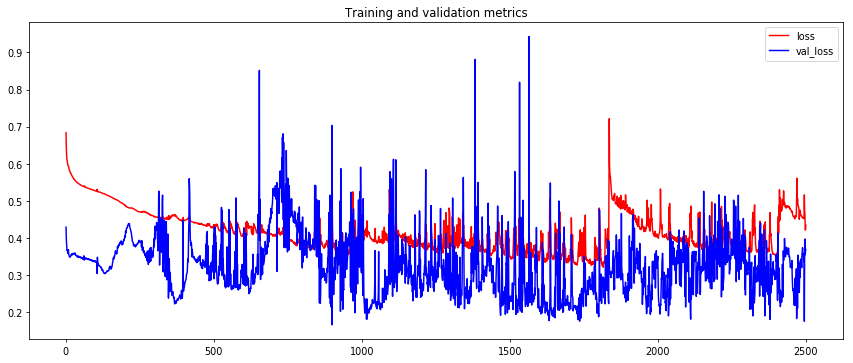

In [38]:
#hyperparameters
hidden_units = 32
epochs = 2500
n_layers=4
l2_weight = 0.0006

model = fc_model(hidden_units, n_layers, epochs, l2_weight, input_shape)

# #fit the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=epochs, verbose=0)

plot_train_validation_metric(history, 'loss', 'val_loss')

### We have 2984 positive and 984 negtive cases. 

In [39]:
#Make predictions for train set
    
X, Y = generator_to_samples_and_targets(train_gen, train_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 2984, 1.0: 984})
F1 score: 0.550588
precision score: 0.653631
recall score: 0.475610
accuracy score: 0.807460
matthews_corrcoef: 0.440763

Confusion matrix:
[[2736  248]
 [ 516  468]]


In [40]:
#Make predictions from dev set
X, Y = generator_to_samples_and_targets(val_gen, val_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 821, 1.0: 11})
F1 score: 0.075949
precision score: 0.044118
recall score: 0.272727
accuracy score: 0.912260
matthews_corrcoef: 0.080700

Confusion matrix:
[[756  65]
 [  8   3]]


In [41]:
#Make predictions for test set
X, Y = generator_to_samples_and_targets(test_gen, test_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 792, 1.0: 40})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.914663
matthews_corrcoef: -0.044211

Confusion matrix:
[[761  31]
 [ 40   0]]


# Try different L2 weights

# Save the best model 

In [42]:
from keras.models import load_model

model.save(params.BEST_MODEL_PATH)  # creates a HDF5 file 'my_model.h5'